# PCA - Stacking
-This notebook will explore the **Stacking** ensemble technique, different base models along with different architectures will be tested looking for an optimal configuration. In this case, the Dataset **PCA** will be used. 
- All data has been previously processed and normalized in the notebook `data_expl_and_preproc.ipynb`.

## Authors
- Izquierdo Alvarez, Mario
- Giménez López, Antonio
- Nuñez Sánchez, Fernando
- Romero Romero, Martín


## Enviroment configuration
- Firstly, the needed packages along with our custom Modules are loaded. Additionally, a `Random.seed()` is set for reproducibility.

In [15]:
using Random
using Statistics
# Including Modules
push!(LOAD_PATH, "../modules")

#Random seed for reproducibility
seed=42
Random.seed!(seed)

TaskLocalRNG()

In [16]:
using HDF5
using Preprocessing
using ModelSelection
using Plotting
using Sk_Modeling
using Flux

## Loading data
- The dataset used in this notebook has been reduced using Feature Selection, using the correlation of the different features with the class as the selection criterion.

The selected features are:
1. RAM
2. Battery Power
3. Screen Height
4. Screen Width  

In [17]:
file = h5open("pca_data.h5", "r")
train_input = read(file, "train_input")
train_tags = read(file, "train_tags")
test_input = read(file, "test_input")
test_tags = read(file, "test_tags")
close(file)

In [18]:
# As the ensemble function handles different models, to work properly with all of them, the tags must be passed as a matrix of Ints

train_tags = map(x -> parse(Int,x), train_tags);
test_tags = map(x -> parse(Int,x), test_tags);

## 10-Fold Cross-Validation

The cross-validation technique is applied to get the performance estimation of the different models. 

In this process, we have tested several configurations trying to approximate an optimal one.

To face this problem, all base models that will be used (ANN, SVM, KNN and Decision Trees) have been tested previously in an individual manner. 

In general scenarios, Stacking is beneficed of the variability between the base models. Thus, we will test this stacking configurations with three base models, living one out. 

As an example, a first approach might be using **Decision Tree**, **SVM**, and **ANN** as the three base models, leaving out the **KNN**. All the base models will use the hyperparameter configuration that have previously demonstrated a major performance.

Finally, all the models will be joined together in a single stacking ensemble and it will be compared to the previous models.

In [19]:
model = :Stacking
# Params for cross validation
N = size(train_input, 1)
k = 10

kFoldIndices = crossvalidation(N,k);
best_models_acc = [];

In [20]:
# Defining the base models of the different staking models
estimators = [
    [:DecisionTree, :KNN, :SVM], # Leave out ANN
    [:DecisionTree, :KNN, :ANN], # Leave out SVM
    [:DecisionTree, :ANN, :SVM], # Leave out KNN
    [:ANN, :KNN, :SVM],          # Leave out DecisionTree
]
hyperparameters = [];

In [21]:
# Compute the inverse of the cov matrix for KNN with mahalanobis distance
cov_matrix = cov(train_input, dims=1)
inv_cov_matrix = inv(cov_matrix)
# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem
stacking_1 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed),
    
]

stacking_2 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),

]
stacking_3 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed),
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed),
]
stacking_4 = [
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed),
]
push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);
push!(hyperparameters, stacking_3);
push!(hyperparameters, stacking_4);

In [22]:
# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4

----- acc means -----
Hyperparams set 1 -> 0.936 ± 0.02
Hyperparams set 3 -> 0.936 ± 0.02
Hyperparams set 4 -> 0.936 ± 0.02
Hyperparams set 2 -> 0.915 ± 0.025

----- sensitivity means -----
Hyperparams set 1 -> 0.936 ± 0.02
Hyperparams set 3 -> 0.936 ± 0.02
Hyperparams set 4 -> 0.936 ± 0.02
Hyperparams set 2 -> 0.915 ± 0.025

----- specificity means -----
Hyperparams set 1 -> 0.978 ± 0.007
Hyperparams set 3 -> 0.978 ± 0.007
Hyperparams set 4 -> 0.978 ± 0.007
Hyperparams set 2 -> 0.97 ± 0.009

----- ppv means -----
Hyperparams set 1 -> 0.938 ± 0.019
Hyperparams set 3 -> 0.938 ± 0.019
Hyperparams set 4 -> 0.938 ± 0.019
Hyperparams set 2 -> 0.919 ± 0.02

----- npv means -----
Hyperparams set 1 -> 0.978 ± 0.007
Hyperparams set 3 -> 0.978 ± 0.007
Hyperparams set 4 -> 0.978 ± 0.007
Hyperparams set 2 -> 0.971 ± 0.008

----- f_score means 

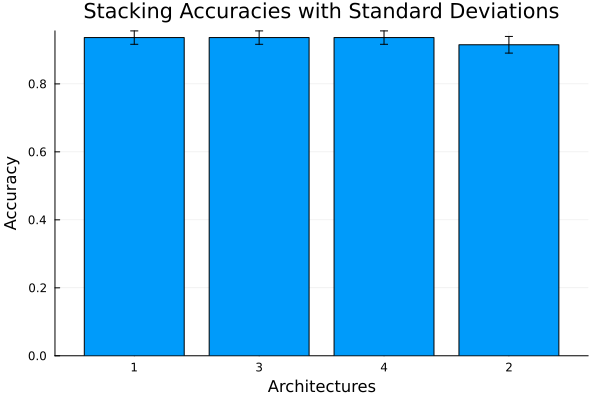

In [23]:
plot_acc_comparison(model, all_metrics)

### Discussion

All the models have similar results

In [24]:
estimators = [
    [:DecisionTree, :KNN, :ANN], # Leave out SVM
    [:DecisionTree, :ANN, :SVM], # Leave out KNN
    [:ANN, :KNN, :SVM],          # Leave out DecisionTree
]
hyperparameters = [];

# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem

stacking_1 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed), #tree params
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)), # KNN params
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
]
stacking_2 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed), #tree params
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed), # SVM params
]
stacking_3 = [
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)), # KNN params
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed),# SVM params
]
push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);
push!(hyperparameters, stacking_3);


all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3

----- acc means -----
Hyperparams set 2 -> 0.936 ± 0.02
Hyperparams set 3 -> 0.936 ± 0.02
Hyperparams set 1 -> 0.915 ± 0.025

----- sensitivity means -----
Hyperparams set 2 -> 0.936 ± 0.02
Hyperparams set 3 -> 0.936 ± 0.02
Hyperparams set 1 -> 0.915 ± 0.025

----- specificity means -----
Hyperparams set 2 -> 0.978 ± 0.007
Hyperparams set 3 -> 0.978 ± 0.007
Hyperparams set 1 -> 0.97 ± 0.009

----- ppv means -----
Hyperparams set 2 -> 0.938 ± 0.019
Hyperparams set 3 -> 0.938 ± 0.019
Hyperparams set 1 -> 0.919 ± 0.02

----- npv means -----
Hyperparams set 2 -> 0.978 ± 0.007
Hyperparams set 3 -> 0.978 ± 0.007
Hyperparams set 1 -> 0.971 ± 0.008

----- f_score means -----
Hyperparams set 2 -> 0.936 ± 0.02
Hyperparams set 3 -> 0.936 ± 0.02
Hyperparams set 1 -> 0.915 ± 0.024

----- err_rate -----
Hyperparams set 2 -> 0.064 ± 0.02
Hyperparams set 3 -> 0.064 ± 0.02
Hyperparams s

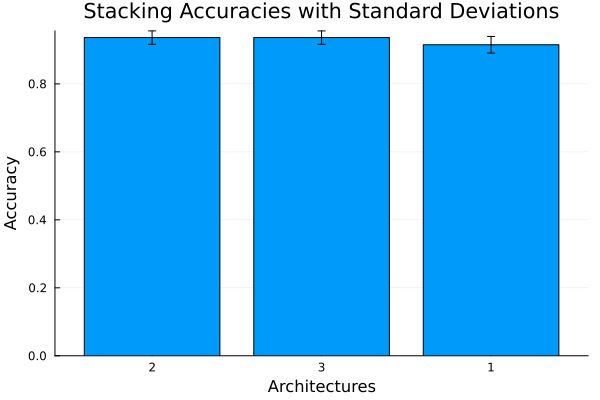

In [25]:
plot_acc_comparison(model, all_metrics)

### Discussion

In [26]:
estimators = [
    [:DecisionTree, :ANN, :SVM, :KNN], # All in
    [:DecisionTree, :ANN, :SVM, :KNN] # All in simple models
]
hyperparameters = [];

# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem

stacking_1 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed),
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
]
stacking_2 = [
    Dict(:max_depth => 10, :criterion => "entropy", :splitter=> "best",:random_state => seed),
    Dict(:hidden_layer_sizes => [128, 64], :activation => "relu", :learning_rate_init => 0.01, :validation_fraction => 0.2, :n_iter_no_change => 20, :max_iter => 2000, :early_stopping=>true, :random_state => seed),
    Dict(:kernel => "linear", :gamma => 1, :C => 5, :degree=>1, :random_state => seed),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
]

push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);

all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2

----- acc means -----
Hyperparams set 1 -> 0.936 ± 0.02
Hyperparams set 2 -> 0.936 ± 0.02

----- sensitivity means -----
Hyperparams set 1 -> 0.936 ± 0.02
Hyperparams set 2 -> 0.936 ± 0.02

----- specificity means -----
Hyperparams set 1 -> 0.978 ± 0.007
Hyperparams set 2 -> 0.978 ± 0.007

----- ppv means -----
Hyperparams set 1 -> 0.938 ± 0.019
Hyperparams set 2 -> 0.938 ± 0.019

----- npv means -----
Hyperparams set 1 -> 0.978 ± 0.007
Hyperparams set 2 -> 0.978 ± 0.007

----- f_score means -----
Hyperparams set 1 -> 0.936 ± 0.02
Hyperparams set 2 -> 0.936 ± 0.02

----- err_rate -----
Hyperparams set 1 -> 0.064 ± 0.02
Hyperparams set 2 -> 0.064 ± 0.02


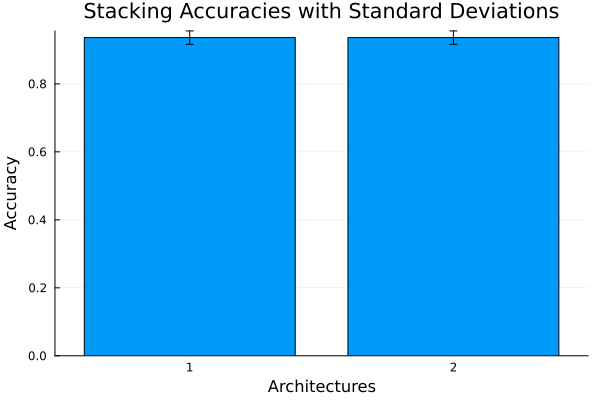

In [27]:
plot_acc_comparison(model, all_metrics)

## Final discussion

- All configurations have the same results, so it is difficult to choose one like the best ensemble. So we would choose one, but it coul be other. This final ensemlbe is:

1. Decision Tree
2. KNN
3. SVM

The results in accuracy are: **0.936 ± 0.02**

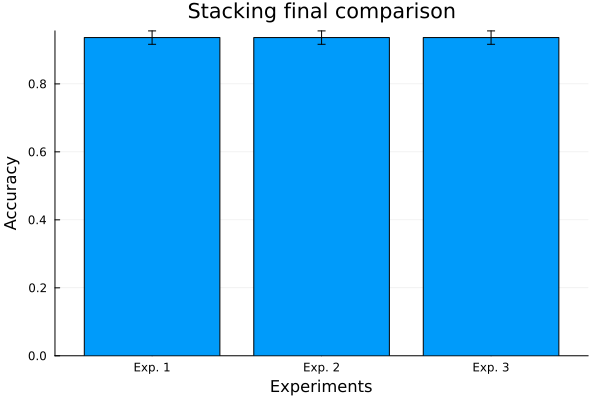

In [29]:
plot_final_comparison("Stacking final comparison", best_models_acc)